# Transformer model

## Preparing the data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

train = pd.read_csv('../../processed-data/train_data.csv')
test = pd.read_csv('../../processed-data/test_data.csv')

In [ ]:
data = pd.concat([train, test], axis=0)

data_wide = data.pivot(
    index='date',
    columns='symbol',
    values=[
        'open',
        'high',
        'low',
        'close',
        'volume',
        'daily_variation',
        'daily_return',
        '7day_SMA',
        '7day_STD',
        '30day_SMA',
        '30day_STD',
        '7day_WMA',
        '30day_WMA',
        '7day_EMA',
        '30day_EMA',
        'momentum',
        'MACD',
        'MACD_signal',
        'MACD_hist',
        'RSI',
        'slowk',
        'slowd'
    ]
)

data_wide.index = pd.to_datetime(data_wide.index)
data_wide = data_wide.sort_index()
data_wide.head()

open                                                      \
symbol            BP    CL1       CVX   EQNR    NG1        OXY      SHEL   
date                                                                       
2009-11-26       NaN  77.80       NaN    NaN  5.131        NaN       NaN   
2009-11-27  56.71001    NaN  77.63000  24.56    NaN  77.364289  59.48000   
2009-11-30  57.03000  76.05  77.85001  24.61  5.184  77.479409  59.74001   
2009-12-01  58.32001  77.35  79.10001  25.17  4.820  78.678484  60.57001   
2009-12-02  58.53999  77.90  78.99001  25.56  4.682  78.668882  61.00999   

                          high         ...      slowk                 slowd  \
symbol           XOM        BP    CL1  ...       SHEL        XOM         BP   
date                                   ...                                    
2009-11-26       NaN       NaN  77.94  ...        NaN        NaN        NaN   
2009-11-27  74.64999  58.38800    NaN  ...  49.827837  73.343674  56.673127   
2009-11-30  74.49001  57.59000  78.00  ...  51.255367  69.774100  57.830492   
2009-12-01  76.00000  58.78999  79.04  ...  52.158323  67.940530  59.238842   
2009-12-02  75.97000  59.00000  78.59  ...  51.676358  61.295335  61.339002   

                                                                              \
symbol            CL1        CVX       EQNR        NG1        OXY       SHEL   
date                                                                           
2009-11-26  32.268092        NaN        NaN  60.852986        NaN        NaN   
2009-11-27        NaN  62.657971  62.281543        NaN  49.573255  47.668865   
2009-11-30  32.735477  66.011121  62.597456  71.258669  54.789327  49.568245   
2009-12-01  40.243795  68.487747  60.062446  72.862814  57.429462  51.080509   
2009-12-02  51.315610  66.435337  56.214564  65.095487  57.023200  51.696683   

                       
symbol            XOM  
date                   
2009-11-26        NaN  
2009-11-27  79.441080  
2009-11-30  75.226996  
2009-12-01  70.352768  
2009-12-02  66.336655  

[5 rows x 176 columns]

### Forward-filling missing values and casting to float32

In [ ]:
data_wide = data_wide.loc['2009-11-30':]
data_wide = data_wide.asfreq('D')
data_wide.ffill(inplace=True)
data_wide = data_wide.astype('float32')

## Creating TimeSeries dataset

### Targets TimeSeries

<Axes: xlabel='date'>

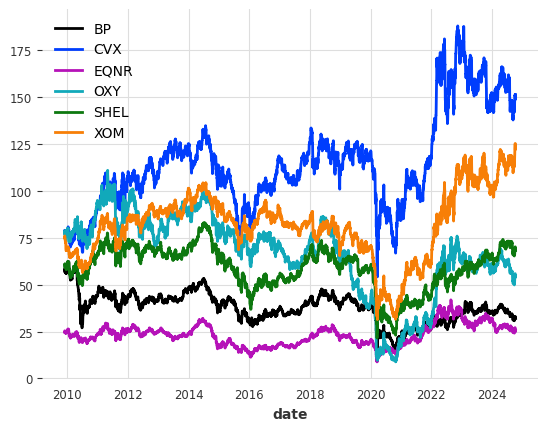

In [ ]:
from darts import TimeSeries

targets = TimeSeries.from_dataframe(
    data_wide['close'][['BP', 'CVX', 'EQNR', 'OXY', 'SHEL', 'XOM']],
    freq='D',
    )

targets.plot()

### Past Covariates TimeSeries

<Axes: xlabel='date'>

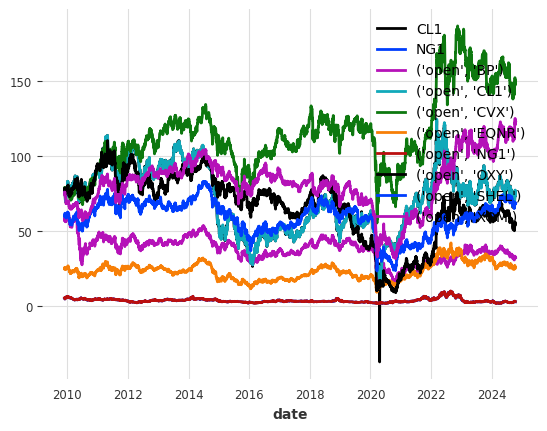

In [ ]:
from darts import concatenate

past_covariates_close = TimeSeries.from_dataframe(
    data_wide['close'][["CL1", "NG1"]],
    freq='D',
    )

past_covariates_remainder = TimeSeries.from_dataframe(
    data_wide[['open',
        'high',
        'low',
        'volume',
        'daily_variation',
        'daily_return',
        '7day_SMA',
        '7day_STD',
        '30day_SMA',
        '7day_WMA',
        '30day_WMA',
        '7day_EMA',
        '30day_EMA',
        'momentum',
        'MACD',
        'MACD_signal',
        'MACD_hist',
        'RSI',
        'slowk',
        'slowd']],
    freq='D',
    )

past_covariates = concatenate([past_covariates_close, past_covariates_remainder], axis=1)
past_covariates.plot()

## Splitting the data

### Splitting holdout test set

<Axes: xlabel='date'>

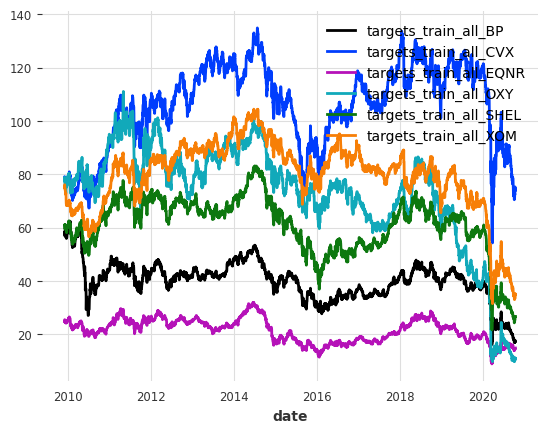

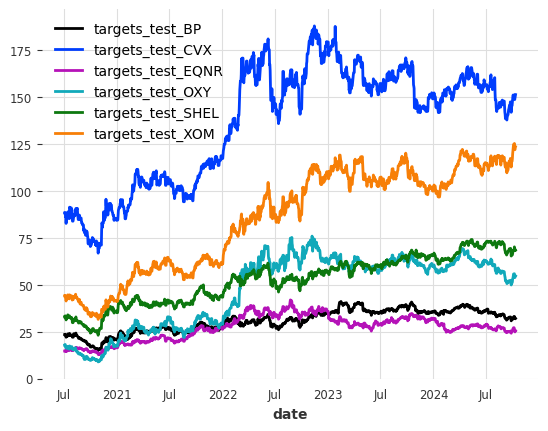

In [ ]:
from darts.utils.model_selection import train_test_split
test_size = 1461
input_size = 100
targets_train_all, targets_test = train_test_split(targets, test_size=test_size, axis=1, input_size=input_size, horizon=1, vertical_split_type="model-aware")
past_covariates_train_all, past_covariates_test = train_test_split(past_covariates, test_size=test_size, axis=1, input_size=input_size, horizon=1, vertical_split_type="model-aware")
targets_train_all.plot(label='targets_train_all')
targets_test.plot(new_plot=True, label='targets_test')

### Splitting train and validation sets

<Axes: xlabel='date'>

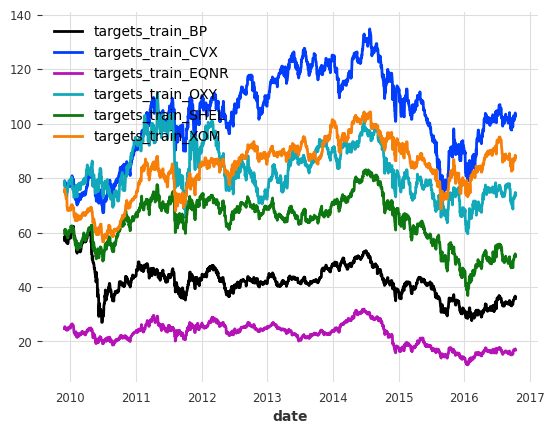

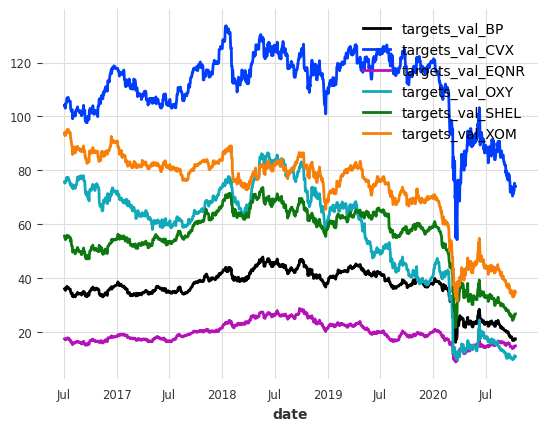

In [ ]:
targets_train, targets_val = train_test_split(targets_train_all, test_size=test_size, axis=1, input_size=input_size, horizon=1, vertical_split_type="model-aware")
past_covariates_train, past_covariates_val = train_test_split(past_covariates_train_all, test_size=test_size, axis=1, input_size=input_size, horizon=1, vertical_split_type="model-aware")
targets_train.plot(label='targets_train')
targets_val.plot(new_plot=True, label='targets_val')

## Preprocessing the train and validation sets

### Scaling entire train set and test set (for evaluation)

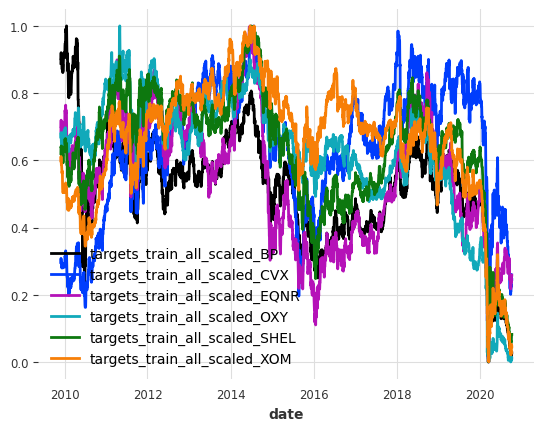

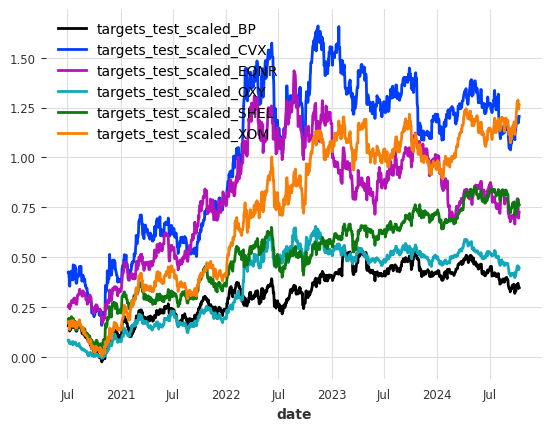

In [ ]:
from darts.dataprocessing.transformers.scaler import Scaler

targets_scaler_all = Scaler()
targets_train_all_scaled = targets_scaler_all.fit_transform(targets_train_all)
targets_test_scaled = targets_scaler_all.transform(targets_test)
targets_train_all_scaled.plot(new_plot=True, label='targets_train_all_scaled')
targets_test_scaled.plot(new_plot=True, label='targets_test_scaled')

past_covariates_scaler_all = Scaler()
past_covariates_train_all_scaled = past_covariates_scaler_all.fit_transform(past_covariates_train_all)
past_covariates_test_scaled = past_covariates_scaler_all.transform(past_covariates_test)

### Scaling train and validation sets

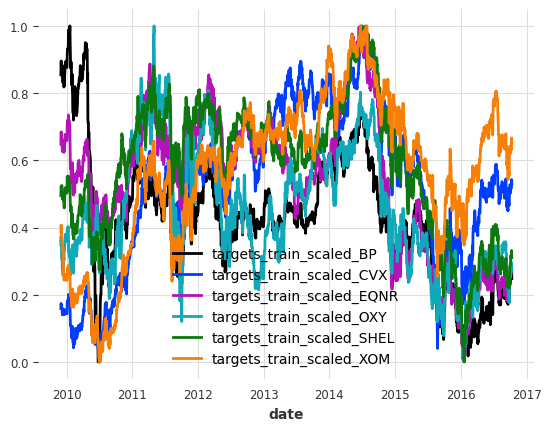

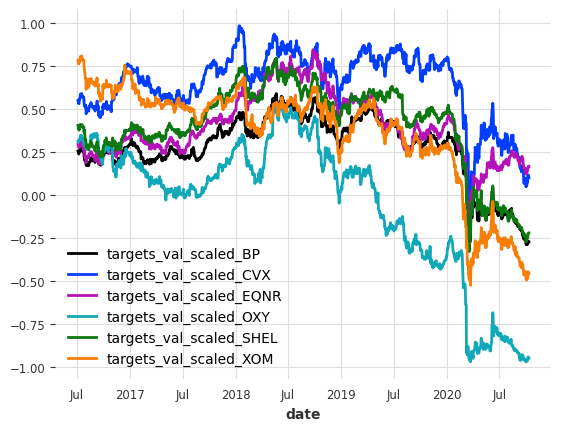

In [ ]:
targets_scaler = Scaler()
targets_train_scaled = targets_scaler.fit_transform(targets_train)
targets_val_scaled = targets_scaler.transform(targets_val)
targets_train_scaled.plot(new_plot=True, label='targets_train_scaled')
targets_val_scaled.plot(new_plot=True, label='targets_val_scaled')

past_covariates_scaler = Scaler()
past_covariates_train_scaled = past_covariates_scaler.fit_transform(past_covariates_train)
past_covariates_val_scaled = past_covariates_scaler.transform(past_covariates_val)

### Training models

#### Transformer

In [ ]:
import numpy as np
import optuna
from darts.metrics import mae
from darts.models import TransformerModel
from pytorch_lightning.callbacks import EarlyStopping


def build_fit_transformer_model(
        val_series,
        val_past_covariates,
        input_size=100,
        num_encoder_layers=4,
        num_decoder_layers=4,
        dropout=0.1,
        activation="GLU",
        nhead=4,
        dim_per_head=32,
):

    my_stopper = EarlyStopping(
        monitor="val_loss",
        patience=5,
        min_delta=0.01,
        mode='min',
    )
    pl_trainer_kwargs = {"callbacks": [my_stopper]}

    transformer_model = TransformerModel(
        model_name="transformer",
        output_chunk_length=1,
        random_state=42,
        save_checkpoints=True,
        force_reset=True,
        input_chunk_length=input_size,
        pl_trainer_kwargs=pl_trainer_kwargs,
        num_encoder_layers=num_encoder_layers,
        num_decoder_layers=num_decoder_layers,
        dropout=dropout,
        activation=activation,
        nhead=nhead,
        d_model=dim_per_head * nhead,
    )

    transformer_model.fit(
        series=targets_train_scaled,
        past_covariates=past_covariates_train_scaled,
        val_series=val_series,
        val_past_covariates=val_past_covariates,
        verbose=False,
    )

    best_transformer_model = transformer_model.load_from_checkpoint(model_name='transformer', best=True)
    return best_transformer_model

def objective(trial):
    input_size = trial.suggest_int("input_size", 5, 105, step=10)
    num_encoder_layers = trial.suggest_int("num_encoder_layers", 2, 8)
    num_decoder_layers = trial.suggest_int("num_decoder_layers", 2, 8)
    dropout = trial.suggest_float("dropout", 0.1, 0.4)
    nhead = trial.suggest_int("nhead", 2, 14, step=4)
    dim_per_head = trial.suggest_int("dim_per_head", 2, 30, step=4)
    activation = trial.suggest_categorical("activation", ["GELU", "GEGLU", "SwiGLU"])

    # Resplit the validation set to account for the new input size
    _, targets_val = train_test_split(targets_train_all, test_size=test_size, axis=1, input_size=input_size, horizon=1, vertical_split_type="model-aware")
    _, past_covariates_val = train_test_split(past_covariates_train_all, test_size=test_size, axis=1, input_size=input_size, horizon=1, vertical_split_type="model-aware")

    # Scale the new validation set
    targets_val_scaled = targets_scaler.transform(targets_val)
    past_covariates_val_scaled = past_covariates_scaler.transform(past_covariates_val)

    best_transformer_model = build_fit_transformer_model(
        val_series=targets_val_scaled,
        val_past_covariates=past_covariates_val_scaled,
        input_size=input_size,
        num_encoder_layers=num_encoder_layers,
        num_decoder_layers=num_decoder_layers,
        dropout=dropout,
        nhead=int(nhead),
        dim_per_head=dim_per_head,
        activation=activation,
    )

    transformer_targets_val_pred = best_transformer_model.historical_forecasts(
        series=targets_val_scaled,
        past_covariates=past_covariates_val_scaled,
        forecast_horizon=1,
        stride=1,
        num_samples=1,
        retrain=False,
        last_points_only=True,
        verbose=False,
    )
    mae_val = mae(targets_scaler.inverse_transform(targets_val_scaled), targets_scaler.inverse_transform(transformer_targets_val_pred))
    return mae_val if mae_val != np.nan else float("inf")

transformer_study = optuna.create_study(direction="minimize", study_name="transformer_study")
transformer_study.optimize(objective, timeout=9000, n_jobs=1, show_progress_bar=True)
print(f"Best value: {transformer_study.best_value}, Best params: {transformer_study.best_trial.params}")

[I 2024-10-27 04:57:00,817] A new study created in memory with name: transformer_study


   0%|          | 00:00/2:30:00

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 04:57:21,798] Trial 0 finished with value: 7.802803039550781 and parameters: {'input_size': 95, 'num_encoder_layers': 5, 'num_decoder_layers': 2, 'dropout': 0.3010685005422357, 'nhead': 10, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 0 with value: 7.802803039550781.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 04:57:53,004] Trial 1 finished with value: 8.293851852416992 and parameters: {'input_size': 25, 'num_encoder_layers': 8, 'num_decoder_layers': 4, 'dropout': 0.22719451691247775, 'nhead': 6, 'dim_per_head': 18, 'activation': 'SwiGLU'}. Best is trial 0 with value: 7.802803039550781.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 04:58:40,277] Trial 2 finished with value: 11.882624626159668 and parameters: {'input_size': 45, 'num_encoder_layers': 5, 'num_decoder_layers': 5, 'dropout': 0.21599114946942974, 'nhead': 14, 'dim_per_head': 26, 'activation': 'GEGLU'}. Best is trial 0 with value: 7.802803039550781.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 04:59:29,512] Trial 3 finished with value: 8.090449333190918 and parameters: {'input_size': 55, 'num_encoder_layers': 7, 'num_decoder_layers': 4, 'dropout': 0.29563320821547223, 'nhead': 10, 'dim_per_head': 18, 'activation': 'GEGLU'}. Best is trial 0 with value: 7.802803039550781.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 04:59:57,581] Trial 4 finished with value: 6.7325873374938965 and parameters: {'input_size': 25, 'num_encoder_layers': 5, 'num_decoder_layers': 2, 'dropout': 0.2250408480622727, 'nhead': 14, 'dim_per_head': 18, 'activation': 'GELU'}. Best is trial 4 with value: 6.7325873374938965.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:00:58,794] Trial 5 finished with value: 6.3656392097473145 and parameters: {'input_size': 35, 'num_encoder_layers': 3, 'num_decoder_layers': 6, 'dropout': 0.3126485549380323, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 5 with value: 6.3656392097473145.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:01:18,322] Trial 6 finished with value: 8.323010444641113 and parameters: {'input_size': 25, 'num_encoder_layers': 6, 'num_decoder_layers': 3, 'dropout': 0.36529000663429123, 'nhead': 2, 'dim_per_head': 14, 'activation': 'GEGLU'}. Best is trial 5 with value: 6.3656392097473145.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:01:39,215] Trial 7 finished with value: 10.48889446258545 and parameters: {'input_size': 75, 'num_encoder_layers': 3, 'num_decoder_layers': 6, 'dropout': 0.1253776863086302, 'nhead': 2, 'dim_per_head': 2, 'activation': 'SwiGLU'}. Best is trial 5 with value: 6.3656392097473145.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:02:57,859] Trial 8 finished with value: 8.442832946777344 and parameters: {'input_size': 15, 'num_encoder_layers': 5, 'num_decoder_layers': 6, 'dropout': 0.3947178828746233, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 5 with value: 6.3656392097473145.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 05:04:00,342] Trial 9 finished with value: 8.705350875854492 and parameters: {'input_size': 95, 'num_encoder_layers': 8, 'num_decoder_layers': 5, 'dropout': 0.29056280908479026, 'nhead': 6, 'dim_per_head': 30, 'activation': 'SwiGLU'}. Best is trial 5 with value: 6.3656392097473145.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:04:25,434] Trial 10 finished with value: 7.9810943603515625 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 8, 'dropout': 0.14160109887568775, 'nhead': 14, 'dim_per_head': 2, 'activation': 'GELU'}. Best is trial 5 with value: 6.3656392097473145.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 05:05:07,352] Trial 11 finished with value: 11.442599296569824 and parameters: {'input_size': 35, 'num_encoder_layers': 3, 'num_decoder_layers': 8, 'dropout': 0.18898394303838734, 'nhead': 14, 'dim_per_head': 22, 'activation': 'GELU'}. Best is trial 5 with value: 6.3656392097473145.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 05:05:36,765] Trial 12 finished with value: 6.69032621383667 and parameters: {'input_size': 65, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.33761752219427504, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GELU'}. Best is trial 5 with value: 6.3656392097473145.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:06:13,791] Trial 13 finished with value: 7.3010573387146 and parameters: {'input_size': 75, 'num_encoder_layers': 3, 'num_decoder_layers': 7, 'dropout': 0.34249313376365886, 'nhead': 10, 'dim_per_head': 10, 'activation': 'GELU'}. Best is trial 5 with value: 6.3656392097473145.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:06:46,368] Trial 14 finished with value: 8.128022193908691 and parameters: {'input_size': 65, 'num_encoder_layers': 4, 'num_decoder_layers': 6, 'dropout': 0.33671272476808334, 'nhead': 6, 'dim_per_head': 6, 'activation': 'GELU'}. Best is trial 5 with value: 6.3656392097473145.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:07:09,167] Trial 15 finished with value: 6.773204803466797 and parameters: {'input_size': 45, 'num_encoder_layers': 2, 'num_decoder_layers': 3, 'dropout': 0.26567840742498555, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GELU'}. Best is trial 5 with value: 6.3656392097473145.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:07:39,964] Trial 16 finished with value: 8.388016700744629 and parameters: {'input_size': 75, 'num_encoder_layers': 4, 'num_decoder_layers': 7, 'dropout': 0.3304122649592522, 'nhead': 10, 'dim_per_head': 6, 'activation': 'GELU'}. Best is trial 5 with value: 6.3656392097473145.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:08:47,087] Trial 17 finished with value: 12.092968940734863 and parameters: {'input_size': 105, 'num_encoder_layers': 4, 'num_decoder_layers': 4, 'dropout': 0.3797580875120821, 'nhead': 14, 'dim_per_head': 22, 'activation': 'GELU'}. Best is trial 5 with value: 6.3656392097473145.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 05:09:09,515] Trial 18 finished with value: 7.967108249664307 and parameters: {'input_size': 55, 'num_encoder_layers': 6, 'num_decoder_layers': 3, 'dropout': 0.26520300567839267, 'nhead': 10, 'dim_per_head': 6, 'activation': 'GELU'}. Best is trial 5 with value: 6.3656392097473145.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:09:44,406] Trial 19 finished with value: 7.377630233764648 and parameters: {'input_size': 45, 'num_encoder_layers': 3, 'num_decoder_layers': 7, 'dropout': 0.3155625110068998, 'nhead': 6, 'dim_per_head': 14, 'activation': 'GEGLU'}. Best is trial 5 with value: 6.3656392097473145.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:10:16,115] Trial 20 finished with value: 8.101818084716797 and parameters: {'input_size': 65, 'num_encoder_layers': 2, 'num_decoder_layers': 5, 'dropout': 0.17219990206370736, 'nhead': 14, 'dim_per_head': 22, 'activation': 'GELU'}. Best is trial 5 with value: 6.3656392097473145.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 05:10:51,574] Trial 21 finished with value: 6.292470932006836 and parameters: {'input_size': 25, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.2401559484844319, 'nhead': 14, 'dim_per_head': 18, 'activation': 'GELU'}. Best is trial 21 with value: 6.292470932006836.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:11:10,680] Trial 22 finished with value: 7.2627854347229 and parameters: {'input_size': 5, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.2577109527638922, 'nhead': 14, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 21 with value: 6.292470932006836.


INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where y

[I 2024-10-27 05:11:36,739] Trial 23 finished with value: 7.707603454589844 and parameters: {'input_size': 35, 'num_encoder_layers': 4, 'num_decoder_layers': 3, 'dropout': 0.35061508066275915, 'nhead': 10, 'dim_per_head': 10, 'activation': 'GELU'}. Best is trial 21 with value: 6.292470932006836.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:12:00,098] Trial 24 finished with value: 6.7381591796875 and parameters: {'input_size': 35, 'num_encoder_layers': 3, 'num_decoder_layers': 2, 'dropout': 0.2898961241115146, 'nhead': 14, 'dim_per_head': 18, 'activation': 'GELU'}. Best is trial 21 with value: 6.292470932006836.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 05:12:23,835] Trial 25 finished with value: 11.5070219039917 and parameters: {'input_size': 15, 'num_encoder_layers': 6, 'num_decoder_layers': 4, 'dropout': 0.23776617231052477, 'nhead': 10, 'dim_per_head': 26, 'activation': 'GELU'}. Best is trial 21 with value: 6.292470932006836.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:12:55,650] Trial 26 finished with value: 6.89994478225708 and parameters: {'input_size': 65, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.19281966942812478, 'nhead': 14, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 21 with value: 6.292470932006836.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:13:18,151] Trial 27 finished with value: 7.774510860443115 and parameters: {'input_size': 15, 'num_encoder_layers': 3, 'num_decoder_layers': 3, 'dropout': 0.3189704148100252, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GELU'}. Best is trial 21 with value: 6.292470932006836.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 05:13:48,430] Trial 28 finished with value: 6.945648193359375 and parameters: {'input_size': 55, 'num_encoder_layers': 2, 'num_decoder_layers': 5, 'dropout': 0.3638065648932623, 'nhead': 10, 'dim_per_head': 6, 'activation': 'SwiGLU'}. Best is trial 21 with value: 6.292470932006836.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:14:07,061] Trial 29 finished with value: 7.607816696166992 and parameters: {'input_size': 85, 'num_encoder_layers': 5, 'num_decoder_layers': 2, 'dropout': 0.28797312759724825, 'nhead': 6, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 21 with value: 6.292470932006836.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:14:32,818] Trial 30 finished with value: 10.269481658935547 and parameters: {'input_size': 35, 'num_encoder_layers': 4, 'num_decoder_layers': 6, 'dropout': 0.308534427843577, 'nhead': 10, 'dim_per_head': 22, 'activation': 'SwiGLU'}. Best is trial 21 with value: 6.292470932006836.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 05:14:59,132] Trial 31 finished with value: 6.793088436126709 and parameters: {'input_size': 25, 'num_encoder_layers': 5, 'num_decoder_layers': 2, 'dropout': 0.20392448791006576, 'nhead': 14, 'dim_per_head': 18, 'activation': 'GELU'}. Best is trial 21 with value: 6.292470932006836.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 05:15:27,628] Trial 32 finished with value: 6.868728160858154 and parameters: {'input_size': 25, 'num_encoder_layers': 5, 'num_decoder_layers': 2, 'dropout': 0.2392032238262319, 'nhead': 14, 'dim_per_head': 18, 'activation': 'GELU'}. Best is trial 21 with value: 6.292470932006836.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:16:20,473] Trial 33 finished with value: 6.8312087059021 and parameters: {'input_size': 45, 'num_encoder_layers': 5, 'num_decoder_layers': 3, 'dropout': 0.22410873283410832, 'nhead': 14, 'dim_per_head': 18, 'activation': 'GELU'}. Best is trial 21 with value: 6.292470932006836.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 05:16:48,318] Trial 34 finished with value: 7.460662841796875 and parameters: {'input_size': 25, 'num_encoder_layers': 6, 'num_decoder_layers': 2, 'dropout': 0.2727867121463794, 'nhead': 14, 'dim_per_head': 26, 'activation': 'GELU'}. Best is trial 21 with value: 6.292470932006836.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:17:24,805] Trial 35 finished with value: 8.22341537475586 and parameters: {'input_size': 35, 'num_encoder_layers': 7, 'num_decoder_layers': 3, 'dropout': 0.2473867327357624, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GEGLU'}. Best is trial 21 with value: 6.292470932006836.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:18:01,252] Trial 36 finished with value: 7.76057767868042 and parameters: {'input_size': 15, 'num_encoder_layers': 7, 'num_decoder_layers': 4, 'dropout': 0.17337309885019714, 'nhead': 2, 'dim_per_head': 18, 'activation': 'SwiGLU'}. Best is trial 21 with value: 6.292470932006836.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:18:33,771] Trial 37 finished with value: 6.390303134918213 and parameters: {'input_size': 45, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.22014915112259784, 'nhead': 14, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 21 with value: 6.292470932006836.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:19:01,624] Trial 38 finished with value: 6.1945953369140625 and parameters: {'input_size': 45, 'num_encoder_layers': 3, 'num_decoder_layers': 2, 'dropout': 0.2790728816828404, 'nhead': 14, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:19:23,222] Trial 39 finished with value: 7.904329776763916 and parameters: {'input_size': 45, 'num_encoder_layers': 3, 'num_decoder_layers': 5, 'dropout': 0.2089336854868679, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GEGLU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:19:47,502] Trial 40 finished with value: 8.50747299194336 and parameters: {'input_size': 45, 'num_encoder_layers': 3, 'num_decoder_layers': 4, 'dropout': 0.27778922415007756, 'nhead': 14, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:20:13,141] Trial 41 finished with value: 7.186275482177734 and parameters: {'input_size': 55, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.3065459749171516, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:20:39,814] Trial 42 finished with value: 7.091966152191162 and parameters: {'input_size': 55, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.3236785463366608, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:21:14,476] Trial 43 finished with value: 7.3903961181640625 and parameters: {'input_size': 35, 'num_encoder_layers': 3, 'num_decoder_layers': 3, 'dropout': 0.3584753770706943, 'nhead': 14, 'dim_per_head': 18, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:21:35,812] Trial 44 finished with value: 6.807862758636475 and parameters: {'input_size': 65, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1003697133519064, 'nhead': 14, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:22:02,347] Trial 45 finished with value: 11.601941108703613 and parameters: {'input_size': 35, 'num_encoder_layers': 3, 'num_decoder_layers': 6, 'dropout': 0.24948917858345948, 'nhead': 14, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:22:32,850] Trial 46 finished with value: 7.37650728225708 and parameters: {'input_size': 45, 'num_encoder_layers': 4, 'num_decoder_layers': 3, 'dropout': 0.29737358369119715, 'nhead': 10, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:23:10,180] Trial 47 finished with value: 8.591156959533691 and parameters: {'input_size': 75, 'num_encoder_layers': 5, 'num_decoder_layers': 7, 'dropout': 0.38225587459290067, 'nhead': 2, 'dim_per_head': 18, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:23:27,503] Trial 48 finished with value: 6.943531036376953 and parameters: {'input_size': 45, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.22787972410620924, 'nhead': 14, 'dim_per_head': 6, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:23:50,912] Trial 49 finished with value: 7.321911334991455 and parameters: {'input_size': 55, 'num_encoder_layers': 2, 'num_decoder_layers': 3, 'dropout': 0.2774669310251109, 'nhead': 14, 'dim_per_head': 2, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:24:12,274] Trial 50 finished with value: 7.139490604400635 and parameters: {'input_size': 85, 'num_encoder_layers': 3, 'num_decoder_layers': 2, 'dropout': 0.3403999854876328, 'nhead': 6, 'dim_per_head': 22, 'activation': 'GEGLU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:24:32,260] Trial 51 finished with value: 7.75850248336792 and parameters: {'input_size': 15, 'num_encoder_layers': 5, 'num_decoder_layers': 2, 'dropout': 0.22321688064669154, 'nhead': 14, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:25:01,068] Trial 52 finished with value: 7.0081562995910645 and parameters: {'input_size': 25, 'num_encoder_layers': 5, 'num_decoder_layers': 2, 'dropout': 0.25841374841279086, 'nhead': 14, 'dim_per_head': 18, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 05:25:27,275] Trial 53 finished with value: 11.563685417175293 and parameters: {'input_size': 25, 'num_encoder_layers': 4, 'num_decoder_layers': 3, 'dropout': 0.17965888030595117, 'nhead': 14, 'dim_per_head': 22, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:25:57,999] Trial 54 finished with value: 6.31144905090332 and parameters: {'input_size': 5, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.19941615263232998, 'nhead': 14, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 05:26:22,865] Trial 55 finished with value: 8.10428237915039 and parameters: {'input_size': 5, 'num_encoder_layers': 3, 'num_decoder_layers': 6, 'dropout': 0.20183395478141472, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 05:26:49,889] Trial 56 finished with value: 6.861887454986572 and parameters: {'input_size': 5, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.23831708444555957, 'nhead': 14, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 05:27:14,967] Trial 57 finished with value: 7.496983051300049 and parameters: {'input_size': 65, 'num_encoder_layers': 3, 'num_decoder_layers': 8, 'dropout': 0.14847248066735075, 'nhead': 10, 'dim_per_head': 10, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 05:27:43,933] Trial 58 finished with value: 6.616249084472656 and parameters: {'input_size': 35, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.21653980062396672, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:28:15,126] Trial 59 finished with value: 7.461357116699219 and parameters: {'input_size': 35, 'num_encoder_layers': 4, 'num_decoder_layers': 3, 'dropout': 0.15263426357170487, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:28:44,636] Trial 60 finished with value: 8.307043075561523 and parameters: {'input_size': 25, 'num_encoder_layers': 8, 'num_decoder_layers': 4, 'dropout': 0.21547926029489575, 'nhead': 6, 'dim_per_head': 14, 'activation': 'SwiGLU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 05:29:07,563] Trial 61 finished with value: 6.899745464324951 and parameters: {'input_size': 45, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.1837130983173874, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:29:39,077] Trial 62 finished with value: 6.996999263763428 and parameters: {'input_size': 55, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.33126523143525866, 'nhead': 14, 'dim_per_head': 18, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:29:58,823] Trial 63 finished with value: 6.766019344329834 and parameters: {'input_size': 35, 'num_encoder_layers': 3, 'num_decoder_layers': 2, 'dropout': 0.19565198289916222, 'nhead': 10, 'dim_per_head': 10, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 05:30:23,561] Trial 64 finished with value: 8.293963432312012 and parameters: {'input_size': 15, 'num_encoder_layers': 4, 'num_decoder_layers': 3, 'dropout': 0.16273419393184763, 'nhead': 14, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:30:57,639] Trial 65 finished with value: 6.2803053855896 and parameters: {'input_size': 45, 'num_encoder_layers': 5, 'num_decoder_layers': 2, 'dropout': 0.21623255596337815, 'nhead': 10, 'dim_per_head': 18, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 05:31:31,867] Trial 66 finished with value: 6.584638595581055 and parameters: {'input_size': 45, 'num_encoder_layers': 5, 'num_decoder_layers': 2, 'dropout': 0.23153587387698826, 'nhead': 10, 'dim_per_head': 18, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:32:04,666] Trial 67 finished with value: 12.141030311584473 and parameters: {'input_size': 45, 'num_encoder_layers': 6, 'num_decoder_layers': 7, 'dropout': 0.23250188112713396, 'nhead': 10, 'dim_per_head': 18, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 05:32:22,156] Trial 68 finished with value: 6.849451065063477 and parameters: {'input_size': 55, 'num_encoder_layers': 5, 'num_decoder_layers': 2, 'dropout': 0.2613655545218996, 'nhead': 6, 'dim_per_head': 22, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:32:56,493] Trial 69 finished with value: 11.668041229248047 and parameters: {'input_size': 45, 'num_encoder_layers': 5, 'num_decoder_layers': 5, 'dropout': 0.24314883353883668, 'nhead': 10, 'dim_per_head': 18, 'activation': 'GEGLU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:33:34,984] Trial 70 finished with value: 7.308361530303955 and parameters: {'input_size': 45, 'num_encoder_layers': 6, 'num_decoder_layers': 3, 'dropout': 0.2142363521127562, 'nhead': 10, 'dim_per_head': 18, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:34:00,932] Trial 71 finished with value: 6.53095006942749 and parameters: {'input_size': 35, 'num_encoder_layers': 5, 'num_decoder_layers': 2, 'dropout': 0.22219333215522458, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 05:34:27,892] Trial 72 finished with value: 6.9417948722839355 and parameters: {'input_size': 35, 'num_encoder_layers': 5, 'num_decoder_layers': 2, 'dropout': 0.2520178375096536, 'nhead': 10, 'dim_per_head': 18, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 05:35:04,750] Trial 73 finished with value: 6.760618686676025 and parameters: {'input_size': 35, 'num_encoder_layers': 5, 'num_decoder_layers': 2, 'dropout': 0.23163891306349316, 'nhead': 10, 'dim_per_head': 30, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:35:28,269] Trial 74 finished with value: 7.529272079467773 and parameters: {'input_size': 35, 'num_encoder_layers': 6, 'num_decoder_layers': 2, 'dropout': 0.20027954567700676, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:35:54,491] Trial 75 finished with value: 7.110903263092041 and parameters: {'input_size': 45, 'num_encoder_layers': 5, 'num_decoder_layers': 2, 'dropout': 0.18803477452059336, 'nhead': 10, 'dim_per_head': 18, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:36:22,907] Trial 76 finished with value: 7.369964599609375 and parameters: {'input_size': 5, 'num_encoder_layers': 6, 'num_decoder_layers': 2, 'dropout': 0.27096951166990824, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 05:37:10,781] Trial 77 finished with value: 7.91880989074707 and parameters: {'input_size': 45, 'num_encoder_layers': 5, 'num_decoder_layers': 6, 'dropout': 0.2079927937123867, 'nhead': 10, 'dim_per_head': 18, 'activation': 'SwiGLU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:37:33,351] Trial 78 finished with value: 6.946518421173096 and parameters: {'input_size': 25, 'num_encoder_layers': 2, 'num_decoder_layers': 3, 'dropout': 0.2833227424277594, 'nhead': 6, 'dim_per_head': 22, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:38:02,141] Trial 79 finished with value: 6.702272415161133 and parameters: {'input_size': 25, 'num_encoder_layers': 5, 'num_decoder_layers': 2, 'dropout': 0.2202896877769198, 'nhead': 14, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:38:22,644] Trial 80 finished with value: 8.019659996032715 and parameters: {'input_size': 55, 'num_encoder_layers': 3, 'num_decoder_layers': 3, 'dropout': 0.2520028668038176, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:38:48,424] Trial 81 finished with value: 6.544973373413086 and parameters: {'input_size': 35, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.2157990740606952, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:39:19,161] Trial 82 finished with value: 6.30571985244751 and parameters: {'input_size': 35, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.23256653524331286, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:39:51,689] Trial 83 finished with value: 6.441526412963867 and parameters: {'input_size': 35, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.208273693834777, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:40:08,898] Trial 84 finished with value: 7.503561496734619 and parameters: {'input_size': 35, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.19547295323343708, 'nhead': 14, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:40:24,011] Trial 85 finished with value: 6.770782470703125 and parameters: {'input_size': 25, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.24458086427557973, 'nhead': 10, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:40:42,245] Trial 86 finished with value: 7.426827907562256 and parameters: {'input_size': 35, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.20742603482782607, 'nhead': 14, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:41:04,903] Trial 87 finished with value: 6.844923496246338 and parameters: {'input_size': 25, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.17392426211132114, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 05:41:32,884] Trial 88 finished with value: 7.039535045623779 and parameters: {'input_size': 15, 'num_encoder_layers': 3, 'num_decoder_layers': 3, 'dropout': 0.22812819078875488, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 05:42:02,740] Trial 89 finished with value: 8.316685676574707 and parameters: {'input_size': 105, 'num_encoder_layers': 3, 'num_decoder_layers': 3, 'dropout': 0.31015097862108837, 'nhead': 14, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:42:17,003] Trial 90 finished with value: 7.5731964111328125 and parameters: {'input_size': 35, 'num_encoder_layers': 3, 'num_decoder_layers': 2, 'dropout': 0.2379416601830683, 'nhead': 6, 'dim_per_head': 18, 'activation': 'SwiGLU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:42:48,795] Trial 91 finished with value: 6.456080913543701 and parameters: {'input_size': 35, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.21105248214776573, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_g

[I 2024-10-27 05:43:14,603] Trial 92 finished with value: 6.6504225730896 and parameters: {'input_size': 35, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.22371512415246234, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where y

[I 2024-10-27 05:43:37,984] Trial 93 finished with value: 7.1716532707214355 and parameters: {'input_size': 25, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.21072737111148782, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:44:02,642] Trial 94 finished with value: 6.920022487640381 and parameters: {'input_size': 45, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.1879434705856694, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 38 with value: 6.1945953369140625.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:44:27,442] Trial 95 finished with value: 6.096449375152588 and parameters: {'input_size': 45, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.20023715700805167, 'nhead': 10, 'dim_per_head': 10, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:44:54,467] Trial 96 finished with value: 7.775249481201172 and parameters: {'input_size': 55, 'num_encoder_layers': 4, 'num_decoder_layers': 5, 'dropout': 0.20068894865925166, 'nhead': 10, 'dim_per_head': 10, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 05:45:09,816] Trial 97 finished with value: 7.142588138580322 and parameters: {'input_size': 45, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.19296537867613114, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 05:45:24,471] Trial 98 finished with value: 6.988494396209717 and parameters: {'input_size': 45, 'num_encoder_layers': 3, 'num_decoder_layers': 2, 'dropout': 0.18167216924815738, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_g

[I 2024-10-27 05:45:52,374] Trial 99 finished with value: 7.144905090332031 and parameters: {'input_size': 45, 'num_encoder_layers': 4, 'num_decoder_layers': 3, 'dropout': 0.20680760253576197, 'nhead': 10, 'dim_per_head': 6, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:46:11,248] Trial 100 finished with value: 6.720362186431885 and parameters: {'input_size': 55, 'num_encoder_layers': 3, 'num_decoder_layers': 2, 'dropout': 0.16293810727686636, 'nhead': 14, 'dim_per_head': 18, 'activation': 'GEGLU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:46:38,015] Trial 101 finished with value: 6.675788879394531 and parameters: {'input_size': 35, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.2194799593833218, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:46:53,237] Trial 102 finished with value: 7.469913482666016 and parameters: {'input_size': 35, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.3005654940370593, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 05:47:16,662] Trial 103 finished with value: 6.891513347625732 and parameters: {'input_size': 45, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.23431274735447713, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:47:45,944] Trial 104 finished with value: 6.75651216506958 and parameters: {'input_size': 25, 'num_encoder_layers': 5, 'num_decoder_layers': 2, 'dropout': 0.226847541737645, 'nhead': 10, 'dim_per_head': 18, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:48:12,059] Trial 105 finished with value: 6.416694641113281 and parameters: {'input_size': 35, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.2006710717774969, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:48:37,077] Trial 106 finished with value: 6.203725337982178 and parameters: {'input_size': 45, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.21012959015569116, 'nhead': 10, 'dim_per_head': 10, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:49:17,208] Trial 107 finished with value: 6.694263458251953 and parameters: {'input_size': 45, 'num_encoder_layers': 3, 'num_decoder_layers': 8, 'dropout': 0.19672140389125242, 'nhead': 10, 'dim_per_head': 6, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:49:42,754] Trial 108 finished with value: 6.866743564605713 and parameters: {'input_size': 55, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.20169517774466902, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:50:07,717] Trial 109 finished with value: 7.031032085418701 and parameters: {'input_size': 45, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.2667094488376635, 'nhead': 10, 'dim_per_head': 10, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:50:38,347] Trial 110 finished with value: 7.297773838043213 and parameters: {'input_size': 55, 'num_encoder_layers': 3, 'num_decoder_layers': 7, 'dropout': 0.24223598911585098, 'nhead': 6, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:51:11,396] Trial 111 finished with value: 6.477138519287109 and parameters: {'input_size': 35, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.21157277548166636, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:51:42,853] Trial 112 finished with value: 6.505465030670166 and parameters: {'input_size': 35, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.21319860035601196, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:52:06,403] Trial 113 finished with value: 7.084245681762695 and parameters: {'input_size': 45, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.176386696236565, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:52:30,796] Trial 114 finished with value: 6.497403621673584 and parameters: {'input_size': 45, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.18948575847092408, 'nhead': 10, 'dim_per_head': 18, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:52:43,798] Trial 115 finished with value: 7.582285404205322 and parameters: {'input_size': 25, 'num_encoder_layers': 3, 'num_decoder_layers': 2, 'dropout': 0.20401800991677932, 'nhead': 2, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:53:02,524] Trial 116 finished with value: 6.640071392059326 and parameters: {'input_size': 35, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.2553983187991352, 'nhead': 10, 'dim_per_head': 10, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 05:53:32,073] Trial 117 finished with value: 7.135093688964844 and parameters: {'input_size': 15, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.34930472843370897, 'nhead': 10, 'dim_per_head': 18, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:54:01,066] Trial 118 finished with value: 6.984285354614258 and parameters: {'input_size': 45, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.1666822614081226, 'nhead': 14, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:54:32,345] Trial 119 finished with value: 6.922632694244385 and parameters: {'input_size': 35, 'num_encoder_layers': 7, 'num_decoder_layers': 2, 'dropout': 0.2934173134024489, 'nhead': 10, 'dim_per_head': 18, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:55:12,596] Trial 120 finished with value: 7.9304585456848145 and parameters: {'input_size': 45, 'num_encoder_layers': 4, 'num_decoder_layers': 6, 'dropout': 0.21794156403412462, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 05:55:44,306] Trial 121 finished with value: 6.454799652099609 and parameters: {'input_size': 35, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.2107467115383248, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:56:11,144] Trial 122 finished with value: 6.337183475494385 and parameters: {'input_size': 35, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.19733032992919664, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:56:34,731] Trial 123 finished with value: 6.288852691650391 and parameters: {'input_size': 5, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.19583313997714977, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:56:58,638] Trial 124 finished with value: 6.234827518463135 and parameters: {'input_size': 5, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'dropout': 0.19859953316503526, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:57:20,060] Trial 125 finished with value: 7.111331939697266 and parameters: {'input_size': 5, 'num_encoder_layers': 3, 'num_decoder_layers': 2, 'dropout': 0.1842806289098956, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 05:57:46,909] Trial 126 finished with value: 7.083755016326904 and parameters: {'input_size': 5, 'num_encoder_layers': 4, 'num_decoder_layers': 3, 'dropout': 0.19578243294065428, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:58:08,720] Trial 127 finished with value: 6.411872863769531 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.19162896871058366, 'nhead': 10, 'dim_per_head': 14, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 05:58:28,099] Trial 128 finished with value: 6.860811710357666 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.19428465486450458, 'nhead': 10, 'dim_per_head': 18, 'activation': 'GELU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:58:45,719] Trial 129 finished with value: 6.148714542388916 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1894392210524629, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:59:06,586] Trial 130 finished with value: 6.479185104370117 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 3, 'dropout': 0.181603480455104, 'nhead': 14, 'dim_per_head': 6, 'activation': 'GEGLU'}. Best is trial 95 with value: 6.096449375152588.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:59:24,452] Trial 131 finished with value: 5.968297481536865 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1857196259431519, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 05:59:43,129] Trial 132 finished with value: 6.460838794708252 and parameters: {'input_size': 15, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.16898254967391008, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:00:00,762] Trial 133 finished with value: 6.123477935791016 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.18553138969528032, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:00:34,133] Trial 134 finished with value: 6.200239181518555 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 5, 'dropout': 0.185682985490189, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:00:52,604] Trial 135 finished with value: 5.98813009262085 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1861765616788561, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:01:11,184] Trial 136 finished with value: 6.036041736602783 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17824929254543678, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:01:27,938] Trial 137 finished with value: 7.4918341636657715 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 4, 'dropout': 0.15654595954969514, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:01:46,025] Trial 138 finished with value: 6.049539089202881 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17680740988293367, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:02:04,194] Trial 139 finished with value: 6.056100368499756 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.176832155893042, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:02:28,796] Trial 140 finished with value: 6.078542232513428 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17470942477711357, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:02:46,351] Trial 141 finished with value: 6.092060089111328 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17411987185669942, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:03:03,694] Trial 142 finished with value: 6.649575710296631 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.14334681037515729, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:03:22,321] Trial 143 finished with value: 6.0947957038879395 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17348848774003411, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:03:40,228] Trial 144 finished with value: 6.036251068115234 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17867743835150487, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:03:58,459] Trial 145 finished with value: 5.970848560333252 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1747734141296487, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:04:10,872] Trial 146 finished with value: 7.339944362640381 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1733191581225284, 'nhead': 14, 'dim_per_head': 6, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:04:34,227] Trial 147 finished with value: 6.419914722442627 and parameters: {'input_size': 15, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.15991986469848538, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:04:58,989] Trial 148 finished with value: 6.281089782714844 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.16887652453967075, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_g

[I 2024-10-27 06:05:16,982] Trial 149 finished with value: 5.9725189208984375 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17739150887661312, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:05:34,612] Trial 150 finished with value: 6.060792922973633 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1779156366041226, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:05:53,731] Trial 151 finished with value: 6.00482702255249 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1773680812947782, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:06:11,706] Trial 152 finished with value: 6.001138687133789 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17679883526308887, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:06:28,459] Trial 153 finished with value: 6.334997653961182 and parameters: {'input_size': 15, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17748998846005629, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:06:53,113] Trial 154 finished with value: 6.0855584144592285 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1524585761242873, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where y

[I 2024-10-27 06:07:17,372] Trial 155 finished with value: 6.287014007568359 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.16729630753212638, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:07:35,701] Trial 156 finished with value: 6.038654804229736 and parameters: {'input_size': 15, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.154076754702271, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:07:53,547] Trial 157 finished with value: 6.259191036224365 and parameters: {'input_size': 15, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1347013286732554, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:08:13,993] Trial 158 finished with value: 6.7549824714660645 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.15220909896253496, 'nhead': 14, 'dim_per_head': 6, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:08:31,963] Trial 159 finished with value: 6.3168511390686035 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.15894063139680198, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:08:51,238] Trial 160 finished with value: 6.676179885864258 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.13814266681122656, 'nhead': 14, 'dim_per_head': 6, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:09:08,919] Trial 161 finished with value: 6.42296838760376 and parameters: {'input_size': 15, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1709439800637241, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:09:27,717] Trial 162 finished with value: 6.092129230499268 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17841007348515192, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 131 with value: 5.968297481536865.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:09:45,254] Trial 163 finished with value: 5.9604949951171875 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17768011875146958, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 163 with value: 5.9604949951171875.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:10:03,448] Trial 164 finished with value: 6.063673496246338 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17949978441110392, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 163 with value: 5.9604949951171875.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:10:21,743] Trial 165 finished with value: 6.423834323883057 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.12147997265967266, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 163 with value: 5.9604949951171875.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:10:39,989] Trial 166 finished with value: 6.343214511871338 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1622202931445167, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 163 with value: 5.9604949951171875.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:10:57,410] Trial 167 finished with value: 6.541257858276367 and parameters: {'input_size': 15, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1496745393079796, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 163 with value: 5.9604949951171875.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:11:15,000] Trial 168 finished with value: 6.039896488189697 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1789165007844613, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 163 with value: 5.9604949951171875.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:11:33,242] Trial 169 finished with value: 6.140299320220947 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.18034546185347525, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 163 with value: 5.9604949951171875.


INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where y

[I 2024-10-27 06:11:51,529] Trial 170 finished with value: 6.476690769195557 and parameters: {'input_size': 15, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.16560110370084943, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 163 with value: 5.9604949951171875.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:12:09,171] Trial 171 finished with value: 6.048877239227295 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17495158793126928, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 163 with value: 5.9604949951171875.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:12:34,048] Trial 172 finished with value: 5.881434917449951 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.15530346704402695, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:12:52,247] Trial 173 finished with value: 6.033775329589844 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17888377702717354, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:13:11,040] Trial 174 finished with value: 6.113969802856445 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.18233763630632197, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:13:29,452] Trial 175 finished with value: 6.290322780609131 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.15773520026019283, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:13:47,089] Trial 176 finished with value: 5.991913318634033 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17963800277441022, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:14:04,765] Trial 177 finished with value: 6.374622344970703 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.16549922687479135, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:14:24,871] Trial 178 finished with value: 6.142250061035156 and parameters: {'input_size': 15, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1845596920077896, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:14:43,962] Trial 179 finished with value: 6.700985431671143 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17034442229906915, 'nhead': 14, 'dim_per_head': 6, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:15:08,642] Trial 180 finished with value: 6.133148193359375 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.14390747246137883, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:15:26,911] Trial 181 finished with value: 6.028763294219971 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17809582558292625, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:15:45,229] Trial 182 finished with value: 5.968170642852783 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17683680890072764, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:16:09,624] Trial 183 finished with value: 6.072702884674072 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1704706074244269, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:16:28,304] Trial 184 finished with value: 6.1561408042907715 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.18858524869339202, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:16:45,995] Trial 185 finished with value: 6.022623538970947 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17814919073799299, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:17:04,318] Trial 186 finished with value: 6.267706394195557 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1622747251935341, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:17:22,345] Trial 187 finished with value: 6.068618297576904 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1833163637788515, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:17:39,790] Trial 188 finished with value: 6.103135585784912 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.18974301796665433, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:17:56,545] Trial 189 finished with value: 6.368332386016846 and parameters: {'input_size': 15, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17445441611232776, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:18:15,135] Trial 190 finished with value: 6.383033752441406 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.166594516691208, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:18:33,683] Trial 191 finished with value: 5.957421779632568 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17947160273465126, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:18:51,651] Trial 192 finished with value: 6.066411972045898 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.18071034932347316, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:19:09,610] Trial 193 finished with value: 6.124542713165283 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.18729184646814134, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:19:34,023] Trial 194 finished with value: 6.111749172210693 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17257612506873987, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:19:52,563] Trial 195 finished with value: 6.043718338012695 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1771407591867736, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:20:10,286] Trial 196 finished with value: 6.188101291656494 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.18292338771242916, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:20:28,867] Trial 197 finished with value: 6.320438385009766 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1581537540726462, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:20:47,817] Trial 198 finished with value: 6.45454740524292 and parameters: {'input_size': 15, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.16977887203236586, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:21:05,714] Trial 199 finished with value: 6.15866231918335 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.19098143204456355, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:21:24,203] Trial 200 finished with value: 6.398770809173584 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.12871765531797644, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:21:41,931] Trial 201 finished with value: 6.05170202255249 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17702027174341933, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:22:00,318] Trial 202 finished with value: 6.0264201164245605 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17878481613913652, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:22:18,096] Trial 203 finished with value: 5.927306652069092 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.18403535840080337, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:22:36,485] Trial 204 finished with value: 6.112030506134033 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1832494691424118, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:22:54,500] Trial 205 finished with value: 6.4000935554504395 and parameters: {'input_size': 15, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1874477946075192, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:23:12,402] Trial 206 finished with value: 6.573368549346924 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.16324164008139794, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:23:31,456] Trial 207 finished with value: 6.009006500244141 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17947054513738822, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:23:43,970] Trial 208 finished with value: 7.850248336791992 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1904446594061503, 'nhead': 14, 'dim_per_head': 2, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:24:02,721] Trial 209 finished with value: 6.723043441772461 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1683643336804055, 'nhead': 14, 'dim_per_head': 6, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:24:21,061] Trial 210 finished with value: 6.048698425292969 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1823423054697984, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:24:39,123] Trial 211 finished with value: 6.0385918617248535 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1771296940055109, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:24:56,745] Trial 212 finished with value: 6.002807140350342 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.18161007539904864, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:25:15,347] Trial 213 finished with value: 6.1441826820373535 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17216894899550664, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:25:33,134] Trial 214 finished with value: 5.913471221923828 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1852181832868221, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:25:52,413] Trial 215 finished with value: 6.093872547149658 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.18510482294595895, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:26:10,388] Trial 216 finished with value: 6.161186695098877 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.19102228346735334, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:26:28,948] Trial 217 finished with value: 6.083704471588135 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17973374154572955, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:26:46,829] Trial 218 finished with value: 6.063417434692383 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.18532948404256908, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2024-10-27 06:27:08,272] Trial 219 finished with value: 6.060680866241455 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.19353690384775432, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:27:25,980] Trial 220 finished with value: 6.327068328857422 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17459475670653674, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:27:50,812] Trial 221 finished with value: 6.293922424316406 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.16747040090017884, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:28:08,673] Trial 222 finished with value: 5.991512775421143 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.18002977172789844, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:28:27,909] Trial 223 finished with value: 6.038528919219971 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17998342230339764, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:28:45,870] Trial 224 finished with value: 6.076608180999756 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.18252110705588576, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:29:04,425] Trial 225 finished with value: 5.9806389808654785 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.18651151268010294, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:29:22,347] Trial 226 finished with value: 6.1645379066467285 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1877506981286965, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:29:46,697] Trial 227 finished with value: 6.020267486572266 and parameters: {'input_size': 95, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.19469098841326718, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:30:20,916] Trial 228 finished with value: 7.228362560272217 and parameters: {'input_size': 85, 'num_encoder_layers': 8, 'num_decoder_layers': 2, 'dropout': 0.19309312416315902, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:30:39,207] Trial 229 finished with value: 6.006298065185547 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.18570802528461874, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:30:57,359] Trial 230 finished with value: 6.161375045776367 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.18811727956801397, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:31:22,784] Trial 231 finished with value: 6.127952575683594 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17294978085474078, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:31:41,282] Trial 232 finished with value: 6.042024612426758 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.18561506723725685, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:32:05,697] Trial 233 finished with value: 6.128076553344727 and parameters: {'input_size': 95, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.19606348704845492, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:32:31,546] Trial 234 finished with value: 6.040110111236572 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1815229803843826, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:32:56,235] Trial 235 finished with value: 6.182275772094727 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1718862474561183, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:33:14,075] Trial 236 finished with value: 6.093820095062256 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.19244129954477746, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:33:32,808] Trial 237 finished with value: 6.015478610992432 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17772698791441977, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:33:51,757] Trial 238 finished with value: 5.9767632484436035 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.18474379491875853, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:34:09,328] Trial 239 finished with value: 6.1202569007873535 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.18701367607570968, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:34:27,772] Trial 240 finished with value: 5.970266819000244 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.18420794996561343, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:34:47,269] Trial 241 finished with value: 7.107633590698242 and parameters: {'input_size': 75, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.18324456779073242, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:35:05,845] Trial 242 finished with value: 6.05860710144043 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.17509200603179792, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:35:30,541] Trial 243 finished with value: 5.887451171875 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.19140469471199525, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:35:51,756] Trial 244 finished with value: 6.120908737182617 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.19986619078382759, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:36:17,479] Trial 245 finished with value: 6.102813720703125 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1902152607593301, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:36:39,345] Trial 246 finished with value: 6.164978504180908 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1958459119743268, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:36:57,156] Trial 247 finished with value: 6.062919616699219 and parameters: {'input_size': 5, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.18509043643315906, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:37:21,389] Trial 248 finished with value: 6.016511917114258 and parameters: {'input_size': 95, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.16962918958012263, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 172 with value: 5.881434917449951.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:37:48,313] Trial 249 finished with value: 5.872112274169922 and parameters: {'input_size': 95, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.16601409643592607, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 249 with value: 5.872112274169922.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:38:12,274] Trial 250 finished with value: 5.914802074432373 and parameters: {'input_size': 85, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.16208197342610275, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 249 with value: 5.872112274169922.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:38:36,565] Trial 251 finished with value: 5.780972003936768 and parameters: {'input_size': 95, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1604815167445801, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 251 with value: 5.780972003936768.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:39:02,006] Trial 252 finished with value: 5.815110683441162 and parameters: {'input_size': 95, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1626043711983823, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 251 with value: 5.780972003936768.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:40:12,142] Trial 253 finished with value: 8.050183296203613 and parameters: {'input_size': 95, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.16079113531324674, 'nhead': 14, 'dim_per_head': 30, 'activation': 'SwiGLU'}. Best is trial 251 with value: 5.780972003936768.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:40:30,567] Trial 254 finished with value: 6.693722248077393 and parameters: {'input_size': 95, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.15815869778341646, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 251 with value: 5.780972003936768.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:40:56,448] Trial 255 finished with value: 6.193508148193359 and parameters: {'input_size': 85, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.16404757405855647, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 251 with value: 5.780972003936768.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:41:26,362] Trial 256 finished with value: 6.110456943511963 and parameters: {'input_size': 95, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.15112208659474963, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 251 with value: 5.780972003936768.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:41:51,438] Trial 257 finished with value: 5.6371684074401855 and parameters: {'input_size': 95, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.16443056435150163, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 257 with value: 5.6371684074401855.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:42:16,069] Trial 258 finished with value: 6.171573162078857 and parameters: {'input_size': 95, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.14800836357767974, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 257 with value: 5.6371684074401855.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:42:40,577] Trial 259 finished with value: 5.776501178741455 and parameters: {'input_size': 95, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.16391615312144048, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 257 with value: 5.6371684074401855.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:43:14,704] Trial 260 finished with value: 6.545400142669678 and parameters: {'input_size': 95, 'num_encoder_layers': 2, 'num_decoder_layers': 4, 'dropout': 0.15687611086429368, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 257 with value: 5.6371684074401855.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:43:46,101] Trial 261 finished with value: 6.053420543670654 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1643061024635538, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 257 with value: 5.6371684074401855.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:44:11,864] Trial 262 finished with value: 5.843421459197998 and parameters: {'input_size': 95, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.16175263014825042, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 257 with value: 5.6371684074401855.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:44:36,549] Trial 263 finished with value: 6.114072322845459 and parameters: {'input_size': 95, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.15506435342095112, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 257 with value: 5.6371684074401855.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:44:55,127] Trial 264 finished with value: 6.949728488922119 and parameters: {'input_size': 95, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1629605521685643, 'nhead': 14, 'dim_per_head': 6, 'activation': 'GEGLU'}. Best is trial 257 with value: 5.6371684074401855.


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub f

[I 2024-10-27 06:45:45,307] Trial 265 finished with value: 8.271525382995605 and parameters: {'input_size': 95, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.14585728235354112, 'nhead': 14, 'dim_per_head': 26, 'activation': 'GEGLU'}. Best is trial 257 with value: 5.6371684074401855.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:46:04,210] Trial 266 finished with value: 6.586314678192139 and parameters: {'input_size': 95, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.16828451658024846, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 257 with value: 5.6371684074401855.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:46:28,109] Trial 267 finished with value: 6.228806972503662 and parameters: {'input_size': 85, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.15787699815320871, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 257 with value: 5.6371684074401855.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:46:55,683] Trial 268 finished with value: 5.964073181152344 and parameters: {'input_size': 95, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1653520839909412, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 257 with value: 5.6371684074401855.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:47:15,754] Trial 269 finished with value: 6.688605785369873 and parameters: {'input_size': 95, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.16212452225151386, 'nhead': 14, 'dim_per_head': 6, 'activation': 'GEGLU'}. Best is trial 257 with value: 5.6371684074401855.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:47:42,758] Trial 270 finished with value: 5.875141620635986 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.15278767688344846, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 257 with value: 5.6371684074401855.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:48:07,841] Trial 271 finished with value: 5.600667953491211 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.15544077554288205, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 271 with value: 5.600667953491211.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:48:32,282] Trial 272 finished with value: 6.252847671508789 and parameters: {'input_size': 85, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.15363013285088192, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 271 with value: 5.600667953491211.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:49:02,728] Trial 273 finished with value: 8.065817832946777 and parameters: {'input_size': 105, 'num_encoder_layers': 7, 'num_decoder_layers': 2, 'dropout': 0.1549745858655676, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 271 with value: 5.600667953491211.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:49:34,416] Trial 274 finished with value: 5.655134677886963 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1395723516276501, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 271 with value: 5.600667953491211.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:49:49,671] Trial 275 finished with value: 6.89987325668335 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.13867544418664599, 'nhead': 2, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 271 with value: 5.600667953491211.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:50:21,082] Trial 276 finished with value: 5.659826755523682 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.14656057854140714, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 271 with value: 5.600667953491211.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:50:46,705] Trial 277 finished with value: 5.68766975402832 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1424144819328444, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 271 with value: 5.600667953491211.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:51:11,041] Trial 278 finished with value: 6.396602630615234 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 3, 'dropout': 0.1339106072340043, 'nhead': 14, 'dim_per_head': 10, 'activation': 'GEGLU'}. Best is trial 271 with value: 5.600667953491211.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:51:42,191] Trial 279 finished with value: 5.6471991539001465 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.14235953514988628, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 271 with value: 5.600667953491211.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:52:14,359] Trial 280 finished with value: 5.572144985198975 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.14135932412887364, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 280 with value: 5.572144985198975.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:52:39,227] Trial 281 finished with value: 5.560811996459961 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.14169399190712398, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 281 with value: 5.560811996459961.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:53:04,538] Trial 282 finished with value: 5.515073299407959 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.12348717024223604, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 282 with value: 5.515073299407959.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:53:29,321] Trial 283 finished with value: 5.648526668548584 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1260165264296286, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 282 with value: 5.515073299407959.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:53:54,704] Trial 284 finished with value: 5.562437534332275 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.12088201991142178, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 282 with value: 5.515073299407959.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:54:19,623] Trial 285 finished with value: 5.778217315673828 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1131487169607756, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 282 with value: 5.515073299407959.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:54:45,287] Trial 286 finished with value: 5.656100749969482 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.12057193260962946, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 282 with value: 5.515073299407959.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:55:10,750] Trial 287 finished with value: 5.6685028076171875 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.11363280803656908, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 282 with value: 5.515073299407959.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:55:41,773] Trial 288 finished with value: 5.628881931304932 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.11717681977776934, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 282 with value: 5.515073299407959.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:56:00,324] Trial 289 finished with value: 6.804180145263672 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.11392364091786364, 'nhead': 14, 'dim_per_head': 6, 'activation': 'SwiGLU'}. Best is trial 282 with value: 5.515073299407959.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:56:28,454] Trial 290 finished with value: 5.320798397064209 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.11250781208869454, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 06:56:55,585] Trial 291 finished with value: 5.52022123336792 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.11202601846481167, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:57:23,828] Trial 292 finished with value: 5.392153263092041 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.11190574257786935, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:57:48,842] Trial 293 finished with value: 5.660886287689209 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.11008181063070935, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:58:28,082] Trial 294 finished with value: 6.504886150360107 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 5, 'dropout': 0.11122806035674997, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:58:52,969] Trial 295 finished with value: 5.721673965454102 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.10479100895837515, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:59:18,008] Trial 296 finished with value: 5.748507022857666 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.10196499301971368, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 06:59:43,498] Trial 297 finished with value: 5.707047939300537 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.103318773475497, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:00:09,027] Trial 298 finished with value: 5.6500630378723145 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.10066140080598605, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:00:37,675] Trial 299 finished with value: 5.898852825164795 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 3, 'dropout': 0.10587490191694347, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:01:02,998] Trial 300 finished with value: 5.613255977630615 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.12049204695240678, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:01:28,126] Trial 301 finished with value: 5.48138952255249 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.11947741128360038, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:02:19,502] Trial 302 finished with value: 6.7473907470703125 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 8, 'dropout': 0.10014376001069496, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:02:45,168] Trial 303 finished with value: 5.657900333404541 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.11995139577207534, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:03:10,583] Trial 304 finished with value: 5.748716831207275 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.12002576138673474, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:03:35,503] Trial 305 finished with value: 5.7177863121032715 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.12614733397733555, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:04:00,546] Trial 306 finished with value: 5.695530414581299 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.12640774908566169, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:04:25,905] Trial 307 finished with value: 5.6384711265563965 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.12606992131091418, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:04:50,764] Trial 308 finished with value: 5.724181652069092 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.11743154136440481, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:05:22,558] Trial 309 finished with value: 5.504461765289307 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1314379944369213, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 07:05:47,828] Trial 310 finished with value: 5.547824859619141 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.12343432742656904, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 07:06:12,682] Trial 311 finished with value: 5.550497531890869 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.13118509353995203, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:06:32,483] Trial 312 finished with value: 6.8140082359313965 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1285611044379997, 'nhead': 14, 'dim_per_head': 6, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:07:31,148] Trial 313 finished with value: 5.831939220428467 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 7, 'dropout': 0.12135664185012643, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 07:07:56,425] Trial 314 finished with value: 5.491521835327148 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.13153879658489384, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 07:08:22,283] Trial 315 finished with value: 5.683030605316162 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.13306817856630176, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 07:08:47,256] Trial 316 finished with value: 5.457481861114502 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1224049571539064, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 07:09:12,532] Trial 317 finished with value: 5.636163234710693 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.12311963520852594, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub f

[I 2024-10-27 07:09:37,404] Trial 318 finished with value: 5.601251602172852 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1217550105563867, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:10:02,628] Trial 319 finished with value: 5.5803375244140625 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.13136078747689237, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:10:38,791] Trial 320 finished with value: 6.447051525115967 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 3, 'dropout': 0.13077352327999126, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:11:04,370] Trial 321 finished with value: 5.690465927124023 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.12421754265028868, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:11:23,976] Trial 322 finished with value: 6.847174167633057 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.13477265938942715, 'nhead': 6, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:11:42,521] Trial 323 finished with value: 6.841026782989502 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.12594928334163455, 'nhead': 14, 'dim_per_head': 6, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:12:14,285] Trial 324 finished with value: 5.513622760772705 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.13835166424285128, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:12:46,900] Trial 325 finished with value: 5.7382354736328125 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.11634930683290863, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:13:06,061] Trial 326 finished with value: 8.495341300964355 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 4, 'dropout': 0.10980791862157639, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:13:37,632] Trial 327 finished with value: 5.532832622528076 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.13176966621768432, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:14:02,644] Trial 328 finished with value: 5.71714448928833 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.13022720505219565, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:14:34,573] Trial 329 finished with value: 5.626949787139893 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1375219901467073, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:15:23,771] Trial 330 finished with value: 7.397890090942383 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dropout': 0.13614128954716012, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 07:15:48,865] Trial 331 finished with value: 5.725364685058594 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.11814939601853308, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 07:16:14,373] Trial 332 finished with value: 5.703752517700195 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.13843717819092494, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 07:16:40,067] Trial 333 finished with value: 5.705451965332031 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.12973520978039302, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 07:17:05,322] Trial 334 finished with value: 5.82640266418457 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.12288940912898025, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 07:17:30,308] Trial 335 finished with value: 5.720284938812256 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.13079526793740578, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 07:18:13,415] Trial 336 finished with value: 6.388540744781494 and parameters: {'input_size': 105, 'num_encoder_layers': 6, 'num_decoder_layers': 2, 'dropout': 0.13960630919157438, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:18:48,736] Trial 337 finished with value: 6.206779479980469 and parameters: {'input_size': 105, 'num_encoder_layers': 3, 'num_decoder_layers': 2, 'dropout': 0.11610464593373043, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 07:19:14,400] Trial 338 finished with value: 5.365013122558594 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.12226898130968329, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:19:39,582] Trial 339 finished with value: 5.521232604980469 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.12431760109587092, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:20:04,568] Trial 340 finished with value: 5.509875774383545 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.10783742732383893, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:20:29,579] Trial 341 finished with value: 5.6167473793029785 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.111580157981521, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:20:54,984] Trial 342 finished with value: 5.761927127838135 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.11302327046511572, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:21:19,870] Trial 343 finished with value: 5.53532600402832 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.10767221649664586, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:21:39,652] Trial 344 finished with value: 6.757068634033203 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.10861824035382057, 'nhead': 14, 'dim_per_head': 6, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:22:05,697] Trial 345 finished with value: 5.789290904998779 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.10667200377695552, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:22:36,261] Trial 346 finished with value: 5.6967010498046875 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1334753671271549, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:23:06,425] Trial 347 finished with value: 6.489721775054932 and parameters: {'input_size': 105, 'num_encoder_layers': 3, 'num_decoder_layers': 2, 'dropout': 0.11942683749474362, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 07:23:34,032] Trial 348 finished with value: 5.403865814208984 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.11192092285237437, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:23:59,738] Trial 349 finished with value: 5.734866619110107 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1104112973494594, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:24:30,602] Trial 350 finished with value: 5.515815734863281 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.11455271234393041, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:25:02,587] Trial 351 finished with value: 5.409447193145752 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.12205327475042592, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 07:25:27,986] Trial 352 finished with value: 5.511030673980713 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.1161593086653688, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 07:25:52,954] Trial 353 finished with value: 5.5385589599609375 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.11470563749834141, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 07:26:28,648] Trial 354 finished with value: 6.338378429412842 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 3, 'dropout': 0.11433139818638466, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

[I 2024-10-27 07:26:44,709] Trial 355 finished with value: 8.807796478271484 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.10719682119240265, 'nhead': 2, 'dim_per_head': 6, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/m

[I 2024-10-27 07:27:09,742] Trial 356 finished with value: 5.458185195922852 and parameters: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.11634790949190443, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}. Best is trial 290 with value: 5.320798397064209.
Best value: 5.320798397064209, Best params: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.11250781208869454, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}


In [ ]:
print(f"Best value: {transformer_study.best_value}, Best params: {transformer_study.best_trial.params}")

from optuna.visualization import plot_optimization_history, plot_param_importances, plot_contour
plot_optimization_history(transformer_study)

Best value: 5.320798397064209, Best params: {'input_size': 105, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.11250781208869454, 'nhead': 14, 'dim_per_head': 10, 'activation': 'SwiGLU'}


In [ ]:
plot_param_importances(transformer_study)

In [ ]:
plot_contour(transformer_study)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Predicting: |          | 0/? [00:00<?, ?it/s]

7.227808


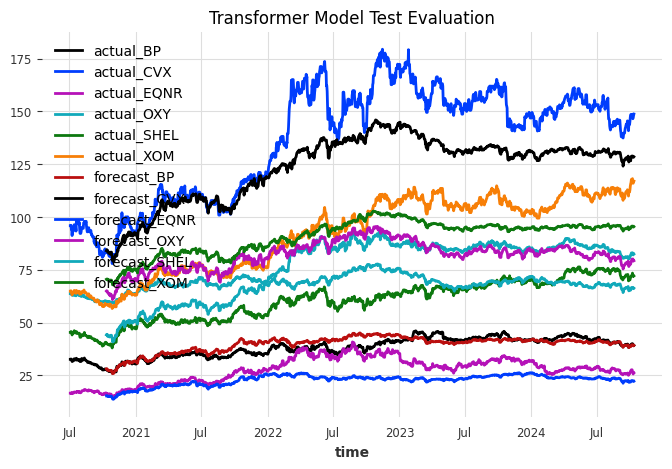

In [ ]:
import numpy as np
from darts.metrics import mae
from darts.models import TransformerModel
from pytorch_lightning.callbacks import EarlyStopping

def get_transformer_test_predictions(study=None):
    input_size = study.best_trial.params["input_size"]
    # Resplit the validation set to account for the new input size
    _, targets_val = train_test_split(targets_train_all, test_size=test_size, axis=1, input_size=input_size, horizon=1, vertical_split_type="model-aware")
    _, past_covariates_val = train_test_split(past_covariates_train_all, test_size=test_size, axis=1, input_size=input_size, horizon=1, vertical_split_type="model-aware")

    # Scale the new validation set
    targets_val_scaled = targets_scaler.transform(targets_val)
    past_covariates_val_scaled = past_covariates_scaler.transform(past_covariates_val)

    best_transformer_model = build_fit_transformer_model(
        val_series=targets_val_scaled,
        val_past_covariates=past_covariates_val_scaled,
        **study.best_trial.params
    )
    best_transformer_model.save()

    # Resplit the test set to account for the new input size
    _, targets_test = train_test_split(targets, test_size=test_size, axis=1, input_size=input_size, horizon=1, vertical_split_type="model-aware")
    _, past_covariates_test = train_test_split(past_covariates, test_size=test_size, axis=1, input_size=input_size, horizon=1, vertical_split_type="model-aware")

    # Scale the new test set
    targets_test_scaled = targets_scaler_all.transform(targets_test)
    past_covariates_test_scaled = past_covariates_scaler_all.transform(past_covariates_test)

    transformer_targets_pred = best_transformer_model.historical_forecasts(
        series=targets_test_scaled,
        past_covariates=past_covariates_test_scaled,
        forecast_horizon=1,
        stride=1,
        num_samples=1,
        retrain=False,
        last_points_only=True,
        verbose=True,
    )
    return transformer_targets_pred

transformer_targets_pred = get_transformer_test_predictions(transformer_study)

plt.figure(figsize=(8, 5))
targets_scaler.inverse_transform(targets_test_scaled).plot(label='actual')
targets_scaler.inverse_transform(transformer_targets_pred).plot(label='forecast')
plt.title('Transformer Model Test Evaluation')
plt.legend()

print(mae(targets_scaler.inverse_transform(targets_test_scaled), targets_scaler.inverse_transform(transformer_targets_pred)))

In [ ]:
pred_df = targets_scaler.inverse_transform(transformer_targets_pred).pd_dataframe()
pred_df.to_csv('transformer_predictions.csv')